# ECS 174 HW1

In [510]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

In [511]:
# show and save a ndarray as an image
def img_save(img_array, file_name, title= '', show = True, cmap=None):

    if show:
        plt.imshow(img_array.astype(np.uint8), cmap = cmap)
        plt.title(title)
        plt.show()

    plt.imsave(file_name, img_array.astype(np.uint8), cmap = cmap)

In [512]:
# Convolution function for filtering
def convolution(image, filter, filter_size):
    # If the image is RGB
    if len(image.shape) == 3:
        # Initialize values
        img_convolved = np.zeros_like(image, dtype=np.float32)
        image_height, image_width, colors = image.shape
             
        # Convolve over each color channel recursively
        for c in range(colors):
            img_convolved[..., c] = convolution(image[..., c], filter, filter_size)
        
        return img_convolved

    # If the image is grayscale
    else:
        img_convolved = np.zeros_like(image, dtype=np.float32)
        image_height, image_width = image.shape

        # Pad the image
        img_padded = np.pad(image, pad_width=((filter_size // 2, filter_size // 2), (filter_size // 2, filter_size // 2)), mode='constant', constant_values=0).astype(np.float32)
     
        # convolve over the image
        for i in range(image_height):
            for j in range(image_width):
                convolution_area = img_padded[i:i + filter_size, j:j + filter_size]
                img_convolved[i, j] = np.sum(convolution_area * filter)
            
        return img_convolved

## Q1

In [513]:
# Gaussian Blur function
def GaussianBlurImage(image, sigma):
    # Set the filter size
    filter_size = 2 * int(sigma * 4 + 0.5) + 1

    # define Gaussian filter
    G_filter = np.zeros((filter_size, filter_size), dtype=np.float32)
    for i in range(filter_size):
        for j in range(filter_size):
            x = i - filter_size // 2
            y = j - filter_size // 2
            G_filter[i, j] = 1 / (2 * np.pi * sigma ** 2) * np.exp(-(x ** 2 + y ** 2)/(2 * sigma ** 2))

    # Normalization
    G_filter /= G_filter.sum()
    
    # Convolve
    img_blurred = convolution(image, G_filter, filter_size)

    return img_blurred

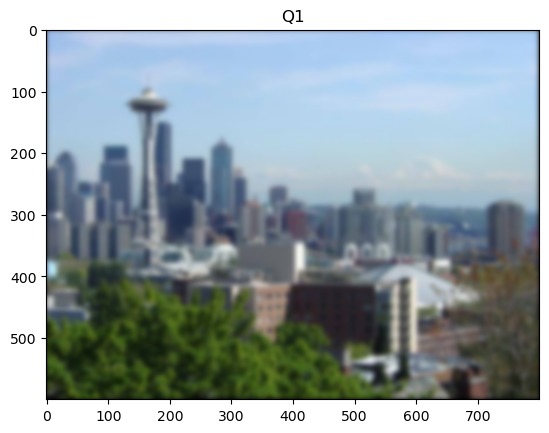

In [514]:
img_seattle = Image.open('/Users/james/Desktop/ECS 174/All/HW 1/hw1_data/Seattle.jpg')
img_seattle = np.array(img_seattle).astype(np.uint8)
img_1 = GaussianBlurImage(img_seattle, sigma=4.0)
img_save(img_1, '1.png', 'Q1', show = True)

## Q2

In [515]:
# Seperable Gaussian blur function divided into vertical and horizontal direction
def SeparableGaussianBlurImage(image, sigma):
    # Set the filter size
    filter_size = 2 * int(sigma * 4 + 0.5) + 1
    
    # define the horizontal filter in 2d
    g2d = np.zeros((filter_size, filter_size), dtype=np.float32)

    for i in range(filter_size):
        for j in range(filter_size):
            x = j - filter_size // 2
            g2d[i, j] = 1 / (np.sqrt(2 * np.pi) * sigma) * np.exp(-(x ** 2)/(2 * sigma ** 2))

    # Normalization
    g2d /= g2d.sum()

    # Change the 2d to 1d
    filter_x = g2d[0:1, :]
    filter_y = filter_x.T
    
    # Convolve both ways
    img_blurred = convolution(image, filter_x, filter_size)
    img_blurred = convolution(img_blurred, filter_y, filter_size)

    return img_blurred

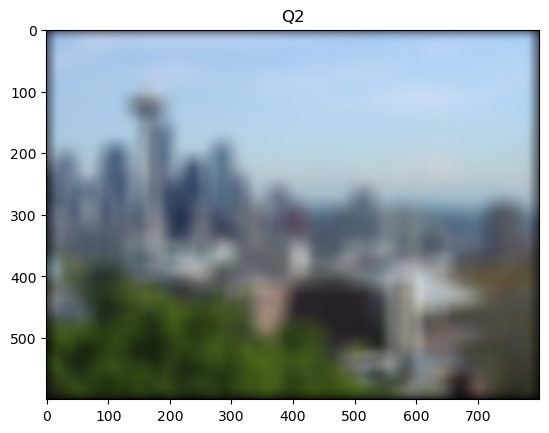

In [516]:
img_2 = SeparableGaussianBlurImage(img_seattle, sigma=4.0)
img_save(img_2, '2.png', 'Q2', show = True)

## Q3


In [517]:
# Sobel function for edge detection
def SobelImage(image):
    # Make the Kernels
    sobel_x = np.array([[-1, 0 ,1],
                        [-2, 0, 2],
                        [-1, 0, 1]],
                        dtype=np.float32)
    sobel_y = np.array([[-1, -2, -1],
                        [0, 0, 0],
                        [1, 2, 1]],
                        dtype=np.float32)

    # Convolve the kernels
    convolve_x = convolution(image, sobel_x, 3)
    convolve_y = convolution(image, sobel_y, 3)

    magnitude = np.sqrt(convolve_x**2 + convolve_y**2)
    orientation = np.arctan2(convolve_y, convolve_x)
    vertical_edge = np.clip(np.abs(convolve_y), 0, 255)
    horizontal_edge = np.clip(np.abs(convolve_x), 0, 255)

    return magnitude, orientation, vertical_edge, horizontal_edge

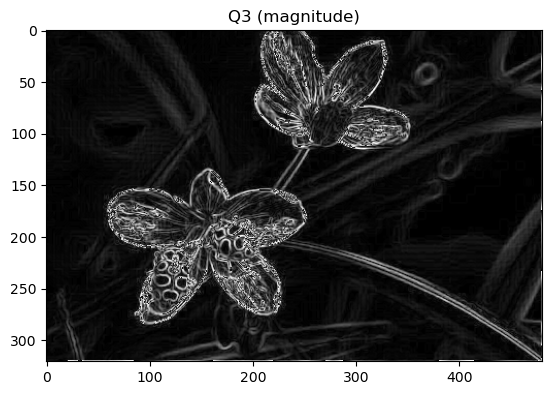

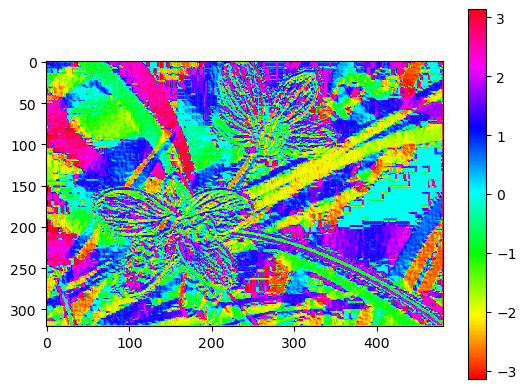

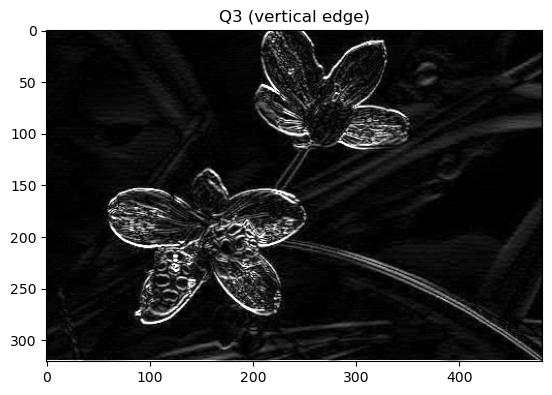

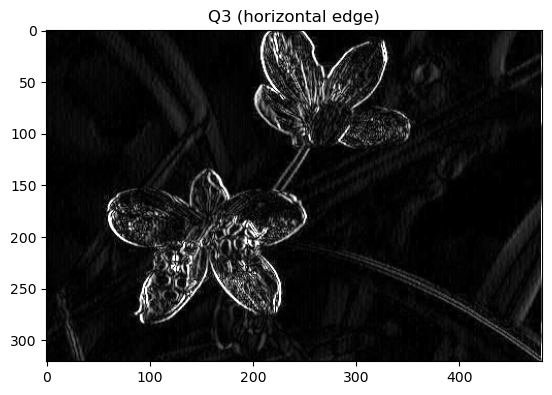

In [518]:
img_ladybug = Image.open('/Users/james/Desktop/ECS 174/All/HW 1/hw1_data/LadyBug.jpg').convert('L')
img_ladybug = np.array(img_ladybug).astype(np.uint8)
magnitude, orientation, vertical_edge, horizontal_edge = SobelImage(img_ladybug)

img_save(magnitude, '5a.png', 'Q3 (magnitude)', show = True, cmap = 'gray')

## orientation is represented in radians, ranging from -pi to +pi, better not normalizing or convert to uint8
plt.imshow(orientation, cmap = plt.cm.hsv) ## no astype(np.uint8)
plt.colorbar()
plt.show()
plt.imsave('5b.png', orientation, cmap = plt.cm.hsv)

img_save(vertical_edge, '5c.png', 'Q3 (vertical edge)', show = True, cmap = 'gray')

img_save(horizontal_edge, '5d.png', 'Q3 (horizontal edge)', show = True, cmap = 'gray')

## Q4

In [519]:
# Interpolation function for nearest neighbor
def NNInterpolation(image, x, y):
    # X and Y are set to the closest pixel
    x_close = round(x)
    y_close = round(y)

    # Set the limits at the edges of the image
    x_close = min(x_close, image.shape[1] - 1)
    y_close = min(y_close, image.shape[0] - 1)

    pixel_value = image[y_close, x_close]

    return pixel_value

# Bilinear interpolation function
def BilinearInterpolation(image, x, y):
    # Get the values of the 4 closest pixels
    x_left = int(np.floor(x))
    x_right = min(int(np.floor(x+1)), image.shape[1] - 1)
    y_top = int(np.floor(y))
    y_bot = min(int(np.floor(y+1)), image.shape[0] - 1)    
    a = x - x_left
    b = y - y_top

    # Computation
    tl = image[y_top, x_left]
    tr = image[y_top, x_right]
    bl = image[y_bot, x_left]
    br = image[y_bot, x_right]

    pixel_value = ((1 - a)*(1 - b)*(tl) +
                   (a)*(1 - b)*(tr) +
                   (1 - a)*(b)*(bl) +
                   (a)*(b)*(br))

    return pixel_value

# Main function for up sampling
def UpSampling(image, factor, interpolation):

    ## img_array.shape = (Height, Width)
    width_up = image.shape[1]*factor
    height_up = image.shape[0]*factor

    img_upsampled = np.zeros((height_up, width_up, image.shape[2]), dtype = np.uint8)

    for i in range(height_up):
        for j in range(width_up):
            x = j / factor
            y = i / factor
            if interpolation == "Bilinear":
                img_upsampled[i][j] = BilinearInterpolation(image, x, y)
            else:
                img_upsampled[i][j] = NNInterpolation(image, x, y)

    return img_upsampled

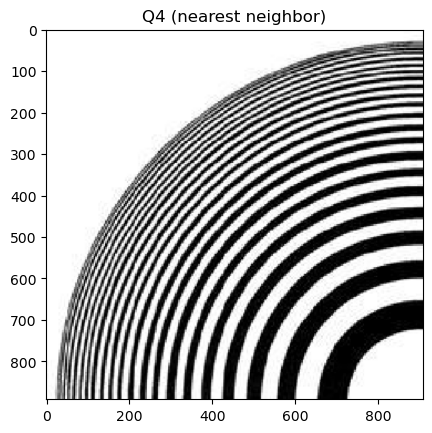

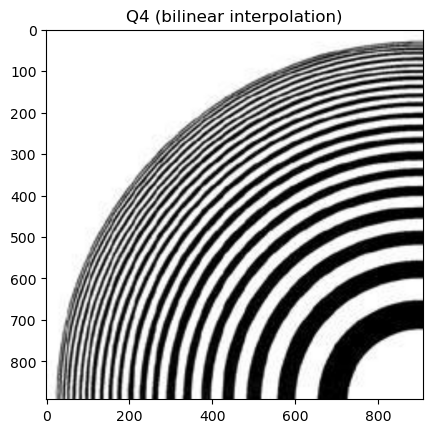

In [520]:
img_moire = Image.open('/Users/james/Desktop/ECS 174/All/HW 1/hw1_data/Moire_small.jpg')
img_moire = np.array(img_moire).astype(np.uint8)
moire_nn = UpSampling(img_moire, factor=4, interpolation="NN")
moire_bilinear = UpSampling(img_moire, factor=4, interpolation="Bilinear")
img_save(moire_nn, '6a.png', 'Q4 (nearest neighbor)', show = True)
img_save(moire_bilinear, '6b.png', 'Q4 (bilinear interpolation)', show = True)

## Q5

In [521]:
# Bilateral blur function
def BilateralImage(image, sigmaS, sigmaI):
    
    # Set the filter size
    filter_size = 2 * int(sigmaS * 4 + 0.5) + 1

    # Define Bilateral filter
    img_blurred = np.zeros_like(image, dtype=np.float32)

    # Define spatial Gaussian kernel
    x = np.arange(-filter_size // 2, filter_size // 2 + 1)
    y = np.arange(-filter_size // 2, filter_size // 2 + 1)
    X, Y = np.meshgrid(x, y)
    spatial_kernel = np.exp(-(X**2 + Y**2) / (2 * sigmaS**2))

    # Iterate for rgb
    for c in range(image.shape[2]): 
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                # Find the region in which we use pixels from
                i_min = max(i - filter_size // 2, 0)
                i_max = min(i + filter_size // 2 + 1, image.shape[0])
                j_min = max(j - filter_size // 2, 0)
                j_max = min(j + filter_size // 2 + 1, image.shape[1])
                region = image[i_min:i_max, j_min:j_max, c]
    
                # Set the center pixel and get the intensity
                center_pixel = image[i, j, c]
                intensity_kernel = np.exp(-((region - center_pixel) ** 2) / (2 * sigmaI**2))
    
                # Get the spatial kernel for the region
                spatial_kernel_region = spatial_kernel[(filter_size // 2 - (i - i_min)):(filter_size // 2 + (i_max - i)),
                                                       (filter_size // 2 - (j - j_min)):(filter_size // 2 + (j_max - j))]
    
                # Combine the spatial and intensity kernel
                bilateral_kernel = spatial_kernel_region * intensity_kernel
                
                # Normalization
                bilateral_kernel /= bilateral_kernel.sum()
    
                # Apply the kernel to the region of interest
                img_blurred[i, j,c] = np.sum(bilateral_kernel * region)

    return img_blurred

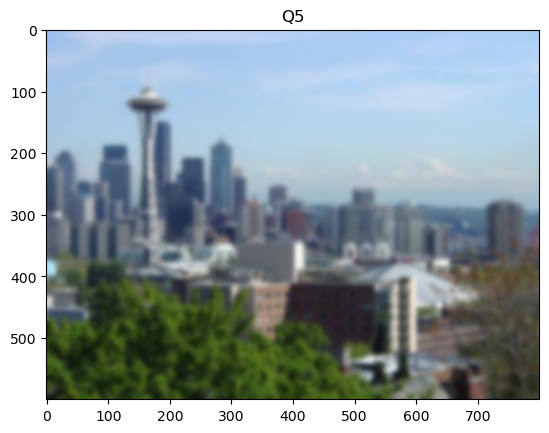

In [522]:
sigmaS = 4
sigmaI = 20
img_bilateral = BilateralImage(img_seattle, sigmaS, sigmaI)
img_save(img_bilateral, 'bilateral.png', 'Q5', show = True)

## Written Q1

In [523]:
# Down sampling function
def DownSampling(image, factor):

    # Get values
    width_down = image.shape[1]//factor
    height_down = image.shape[0]//factor
    img_downsampled = np.zeros((height_down, width_down, image.shape[2]), dtype=np.uint8)

    # Make it smaller
    for i in range(height_down):
        for j in range(width_down):
            img_downsampled[i, j] = np.mean(image[i * factor:(i + 1) * factor, j * factor:(j + 1) * factor], axis=(0, 1))

    return img_downsampled

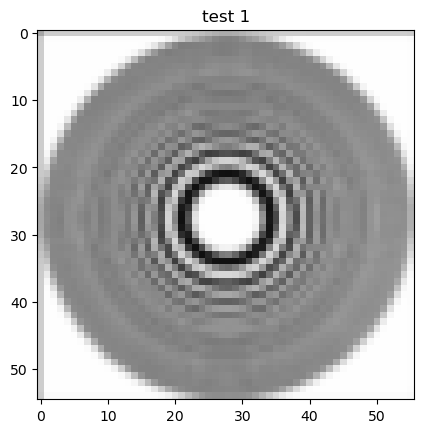

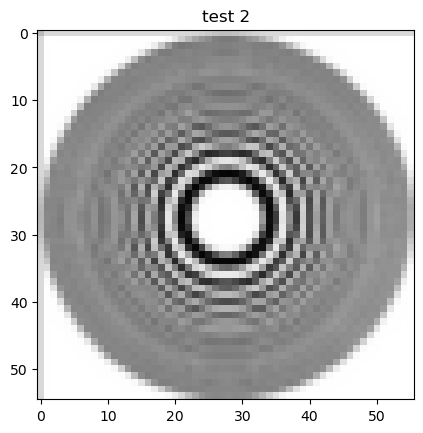

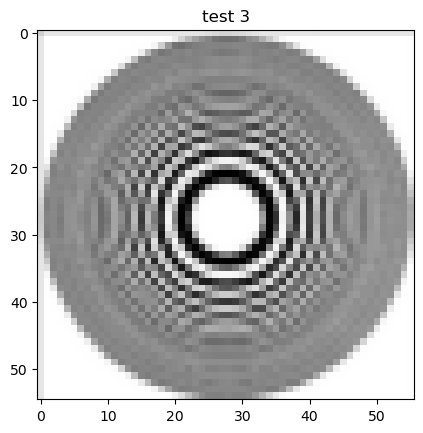

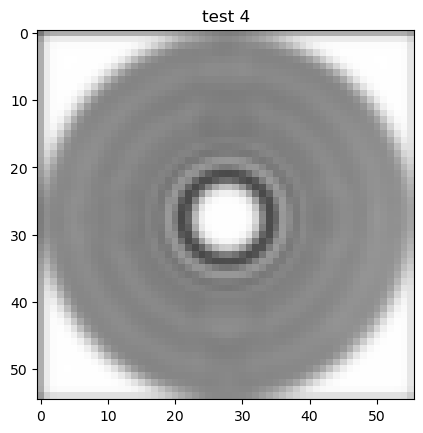

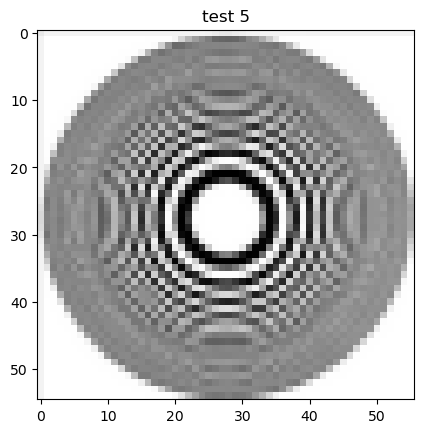

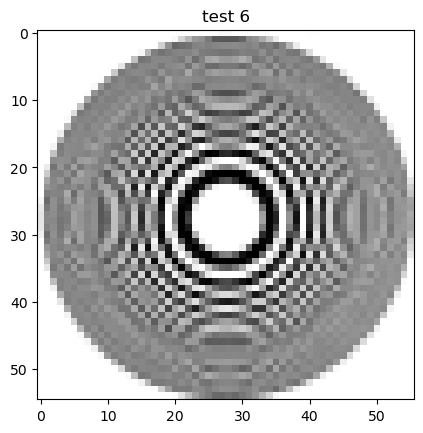

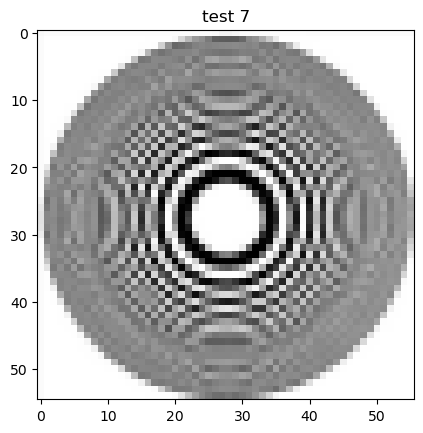

In [524]:
img_moiretest = Image.open('/Users/james/Desktop/ECS 174/All/HW 1/hw1_data/Moire.jpg')
img_moiretest = np.array(img_moiretest).astype(np.uint8)
img_moire1 = GaussianBlurImage(img_moiretest, sigma=4.0)
img_moire2 = GaussianBlurImage(img_moiretest, sigma=3.0)
img_moire3 = GaussianBlurImage(img_moiretest, sigma=2.0)
img_moire4 = GaussianBlurImage(img_moiretest, sigma=8.0)
img_moire5 = GaussianBlurImage(img_moiretest, sigma=1.0)
img_moire7 = GaussianBlurImage(img_moiretest, sigma=0.5)
img_moire1 = DownSampling(img_moire1, factor=8)
img_save(img_moire1, 'test 1.png', 'test 1', show = True)
img_moire2 = DownSampling(img_moire2, factor=8)
img_save(img_moire2, 'test 2.png', 'test 2', show = True)
img_moire3 = DownSampling(img_moire3, factor=8)
img_save(img_moire3, 'test 3.png', 'test 3', show = True)
img_moire4 = DownSampling(img_moire4, factor=8)
img_save(img_moire4, 'test 4.png', 'test 4', show = True)
img_moire5 = DownSampling(img_moire5, factor=8)
img_save(img_moire5, 'test 5.png', 'test 5', show = True)
img_moire6 = DownSampling(img_moiretest, factor=8)
img_save(img_moire6, 'test 6.png', 'test 6', show = True)
img_moire7 = DownSampling(img_moire7, factor=8)
img_save(img_moire7, 'test 7.png', 'test 7', show = True)

In [525]:
# As can be seen by the images, the Gaussian blurring is best when sigma is equal to 1 or a similar
# close number, since the image appears the most clear and has approximately the same amount of aliasing as other values of sigma.

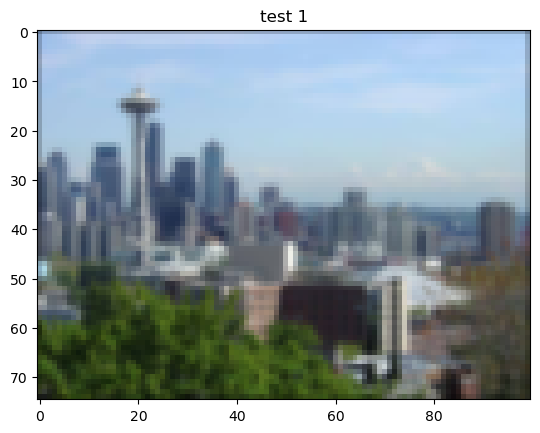

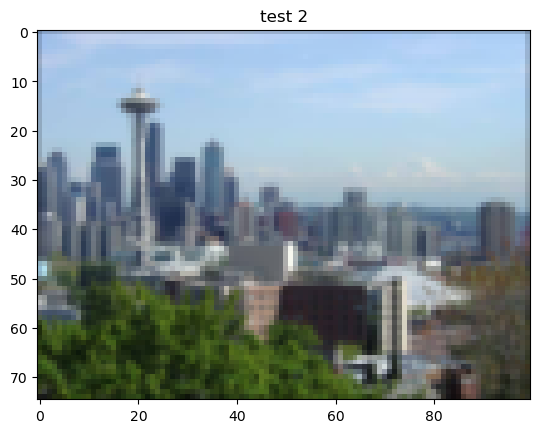

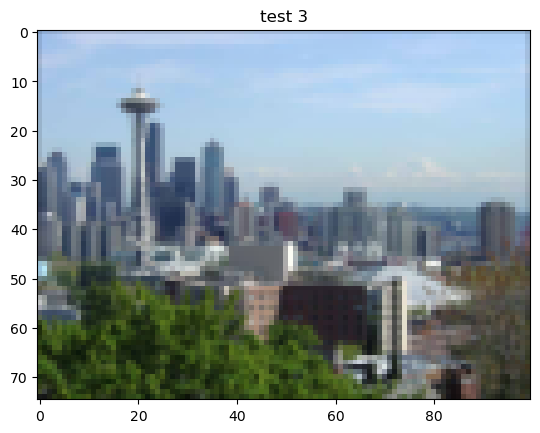

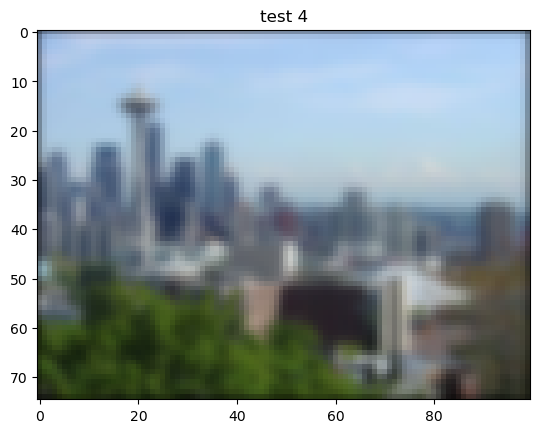

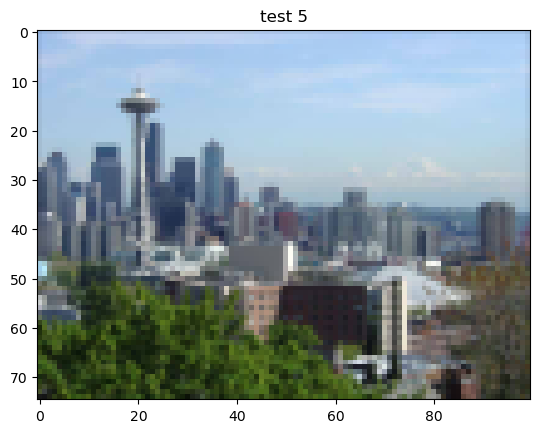

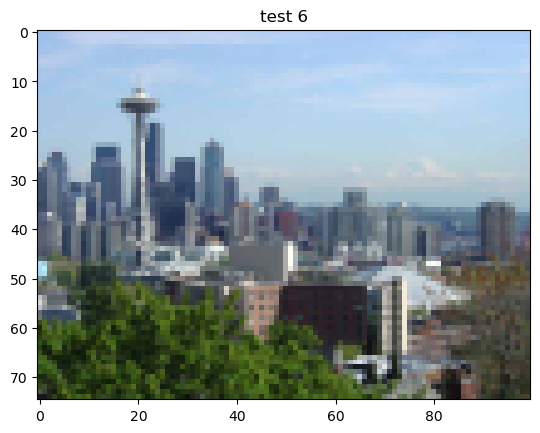

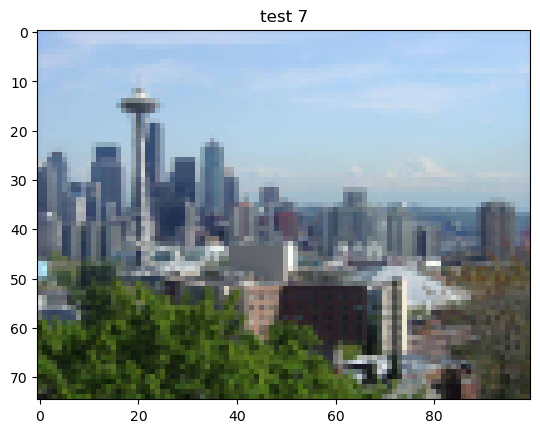

In [526]:
img_seattletest = Image.open('/Users/james/Desktop/ECS 174/All/HW 1/hw1_data/Seattle.jpg')
img_seattletest = np.array(img_seattletest).astype(np.uint8)
img_seattle1 = GaussianBlurImage(img_seattletest, sigma=4.0)
img_seattle2 = GaussianBlurImage(img_seattletest, sigma=3.0)
img_seattle3 = GaussianBlurImage(img_seattletest, sigma=2.0)
img_seattle4 = GaussianBlurImage(img_seattletest, sigma=8.0)
img_seattle5 = GaussianBlurImage(img_seattletest, sigma=1.0)
img_seattle7 = GaussianBlurImage(img_seattletest, sigma=0.5)
img_seattle1 = DownSampling(img_seattle1, factor=8)
img_save(img_seattle1, 'test 1s.png', 'test 1', show = True)
img_seattle2 = DownSampling(img_seattle2, factor=8)
img_save(img_seattle2, 'test 2s.png', 'test 2', show = True)
img_seattle3 = DownSampling(img_seattle3, factor=8)
img_save(img_seattle3, 'test 3s.png', 'test 3', show = True)
img_seattle4 = DownSampling(img_seattle4, factor=8)
img_save(img_seattle4, 'test 4s.png', 'test 4', show = True)
img_seattle5 = DownSampling(img_seattle5, factor=8)
img_save(img_seattle5, 'test 5s.png', 'test 5', show = True)
img_seattle6 = DownSampling(img_seattletest, factor=8)
img_save(img_seattle6, 'test 6s.png', 'test 6', show = True)
img_seattle7 = DownSampling(img_seattle7, factor=8)
img_save(img_seattle7, 'test 7s.png', 'test 7', show = True)

In [527]:
# Since the Seattle image doesn't need to keep the same structure as much as the Moire image to be close to its
# original image, it is better to use less sigma than for the Moire image. A sigma of around 0.5 is the best amount of blur to apply
# from a gaussian filter

## Written Q2

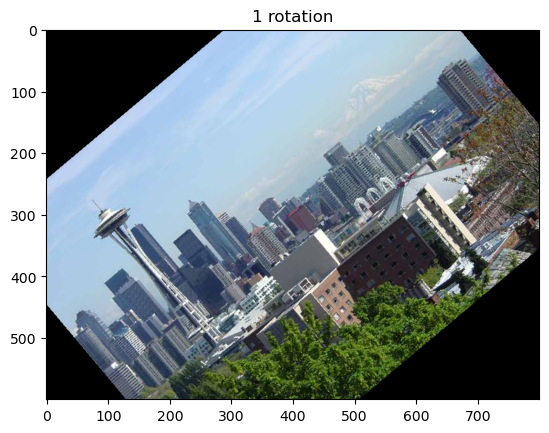

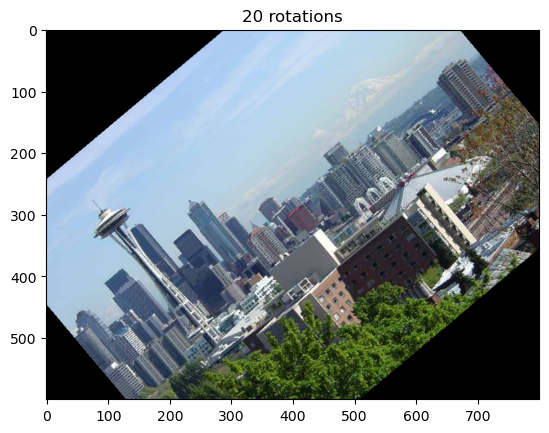

In [528]:
img_seattletest = Image.open('/Users/james/Desktop/ECS 174/All/HW 1/hw1_data/Seattle.jpg')
img_seattlerotate = img_seattletest.rotate(40)
img_seattlerepeat = img_seattletest
for i in range(20):
    img_seattlerepeat = img_seattlerepeat.rotate(2)
img_seattlerotate = np.array(img_seattlerotate).astype(np.uint8)
img_seattlerepeat = np.array(img_seattlerotate).astype(np.uint8)
img_save(img_seattlerotate, '1 rotation.png', '1 rotation', show = True)
img_save(img_seattlerepeat, '20 rotations.png', '20 rotations', show = True)

In [529]:
# Although these two images appear similar, they are not the same because every single time the second image (20 rotations)
# is rotated, it does rounding and interpolation for the pixels in the image, which will cause it to be slightly different from
# the image that was rotated 40 degrees a single time.